## Imports

In [131]:
import numpy as np
import csv, os
from os.path import join
import cv2
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from skimage.registration import phase_cross_correlation
import math

# Helper Functions

In [132]:
def get_rotation_matrix_inverse(angle: float):
    '''
    Input: Delta Rotation of the the stage in radians\n
    Output: Matrix of the shape:\n
    (2 - 2*cos(phi)) ** (1/2) *  [ 1-cos(phi) , -sin(phi) ; sin(phi) , 1-cos(phi) ]
    '''
    determinant = 1/(2.-2.*np.cos(angle))
    matrix = np.matrix([[1.0-np.cos(angle), -np.sin(angle)], [np.sin(angle), 1.0-np.cos(angle)]])
    return(determinant * matrix)

def get_rotation_matrix_offset(angle, origin = (0,0)):
    '''
    Input: Delta Rotation of the the stage in radians, Tuple of rotation center\n
    Output: npmy rotation Matrix 3x3
    '''
    c,s = np.cos(angle), np.sin(angle)
    x,y = origin[0], origin[1]
    matrix = np.array([[c, -s, x - c*x + s*y],[s , c,  y - s*x - c*y],[0,0,1]])
    return(matrix)

def phase_correlate(image_8bit, template_8bit, upsample_factor=25):

    # Determine image sizes
    image_height, image_width = image_8bit.shape
    template_height, template_width = template_8bit.shape
    target_height = max(image_height,template_height)
    target_width = max(image_width,template_width)

    # Pad to largest dimensions
    image_8bit_pad = np.zeros([target_height,target_width],dtype=np.uint8)
    image_8bit_pad[0:image_height,0:image_width] = image_8bit
    template_8bit_pad = np.zeros([target_height,target_width],dtype=np.uint8)
    template_8bit_pad[0:template_height,0:template_width] = template_8bit

    try:
        # Phase correlation with upsampled matrix-multiplication DFT
        shift, error, diffphase = phase_cross_correlation(template_8bit_pad, image_8bit_pad,upsample_factor=upsample_factor)
        match_center_x = template_width / 2 - shift[1]
        match_center_y = template_height / 2 - shift[0]
        transform = np.float32([ [1,0,shift[1]], [0,1,shift[0]] ])
    except NameError:
        # Phase correlation with Hanning window function and 5x5-weighted centroid around peak
        retval, response = cv2.phaseCorrelate(np.float32(template_8bit_pad), np.float32(image_8bit_pad))
        match_center_x = template_width / 2 + retval[0]
        match_center_y = template_height / 2 + retval[1]
        transform = np.float32([ [1,0,-retval[0]], [0,1,-retval[1]] ])
    image_8bit_pad_shifted = cv2.warpAffine(image_8bit_pad, transform, (target_width,target_height) )
    match_score = float(cv2.matchTemplate(template_8bit_pad, image_8bit_pad_shifted, cv2.TM_CCOEFF_NORMED)[0][0])

    return match_center_x, match_center_y, match_score

def printPositionNicely(p):
    print('Position / mm:\nx: {}\ny: {}\nz: {}\nt: {}\nr: {} {}'.format( \
        round(p['x']*1e3,4), round(p['y']*1e3,4), \
        round(p['z']*1e3,4), round(p['t']*57.2968,2),\
        round(p['r']/math.pi * 180 -360,2), \
        round(p['r']/math.pi * 180,2)))

# Load Sample Images and Data from Server

In [133]:
folder = '//samba-pool-plitzko2.biochem.mpg.de/pool-plitzko2/Johann/03-data/06-FIB-SEM/220922_MeteorAutomation/220922_152312_2.5deg_10_MovementTest/'
file = os.path.join(folder, 'position_data.csv')

with open(file, mode='r') as f:
    reader = csv.DictReader(f)
    positions_str = list(reader)


positions = [dict([a, float(x)] for a, x in b.items()) for b in positions_str]
print(positions)
test = positions[0]
print(test)
#for i in range(len(positions)):
#    print(positions[0])
print(positions[0]['r']/math.pi*180 -360)

[{'x': -0.002068291666667, 'y': -0.004378999999999999, 'r': 6.239609575280866, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.0019511250000003332, 'y': -0.004365333333333333, 'r': 6.1959669120726115, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.001925791666667, 'y': -0.004378999999999999, 'r': 6.1523582120263836, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.002007875000000333, 'y': -0.0043908333333333325, 'r': 6.056242463482126, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.0020352083333336664, 'y': -0.004382916666666666, 'r': 6.065038922447835, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.002000041666667, 'y': -0.0044006666666666664, 'r': 6.020581143350858, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.0021054583333336664, 'y': -0.004361416666666666, 'r': 5.9778215223553754, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}, {'x': -0.0020644583333336666, 'y': -0.0043809999

In [134]:
files = []
for file in os.listdir(folder):
    if file.endswith(".jpg"):
        if file.startswith('raw'):
            files.append(file)
            print(file)

raw_image_0.0deg.jpg
raw_image_10.0deg.jpg
raw_image_12.5deg.jpg
raw_image_15.0deg.jpg
raw_image_17.5deg.jpg
raw_image_2.5deg.jpg
raw_image_20.0deg.jpg
raw_image_22.5deg.jpg
raw_image_5.0deg.jpg
raw_image_7.5deg.jpg


# Specify the rotation angle

In [135]:
angle = 12.5
r = np.deg2rad(angle)

# Some obsolete calculations about rotation

In [136]:
pos_rotation_aligned = positions[3]
print(pos_rotation_aligned)
pos_rotation = {'x': -2.1915e-3, 'y': -4.3908e-3, 'z':6.9725e-3, 't':0.0, 'r': r}

# Calculate the difference between the rotated and aligned position
rotation_difference = {key: float(pos_rotation_aligned[key] - pos_rotation.get(key, 0)) for key in pos_rotation_aligned}
print("Rot Diff: {}".format(rotation_difference))


rotation_difference_vector = np.array([[rotation_difference['x']], [rotation_difference['y']]])
print("Rot Diff Vector: {}".format(rotation_difference_vector))

rotation_matrix = get_rotation_matrix_inverse(r)
print("Rot Matrix: {}".format(rotation_matrix))

rotation_center = rotation_matrix * rotation_difference_vector
print("Rot Center mm: {}".format(rotation_center*1e3))

{'x': -0.002007875000000333, 'y': -0.0043908333333333325, 'r': 6.056242463482126, 't': 3.12201998980754e-06, 'z': 0.006972542286750274}
Rot Diff: {'x': 0.0001836249999996667, 'y': -3.333333333226801e-08, 'r': 5.838076306982835, 't': 3.12201998980754e-06, 'z': 4.228675027327655e-08}
Rot Diff Vector: [[ 1.83625000e-04]
 [-3.33333333e-08]]
Rot Matrix: [[ 0.5        -4.56546741]
 [ 4.56546741  0.5       ]]
Rot Center mm: [[0.09196468]
 [0.83831729]]


# Load the corresponding reference and alignment image at the specified angle

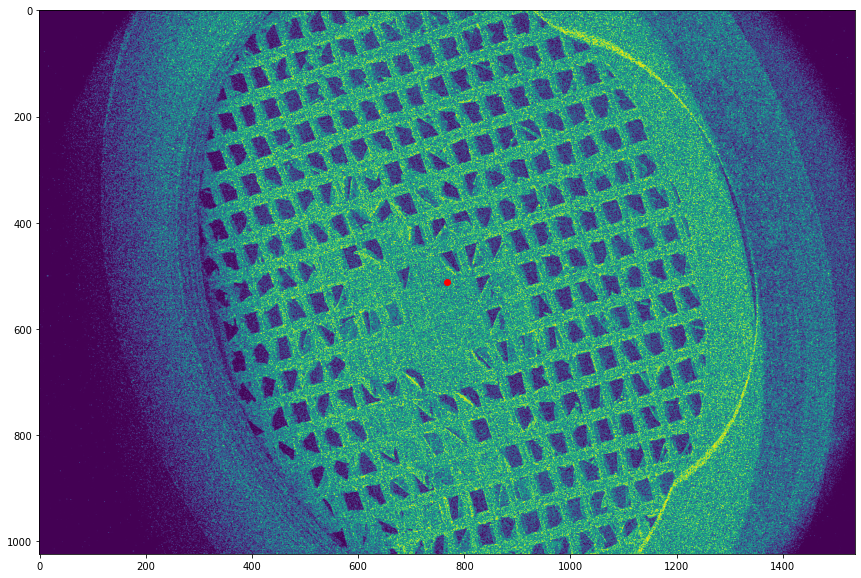

In [137]:
file_reference = [f for f in files if '_0.0' in f]
img_reference = cv2.imread(os.path.join(folder,file_reference[0]),cv2.IMREAD_GRAYSCALE)
plt.imshow(img_reference)
plt.plot(img_alignment.shape[1]/2, img_alignment.shape[0]/2,'ro')

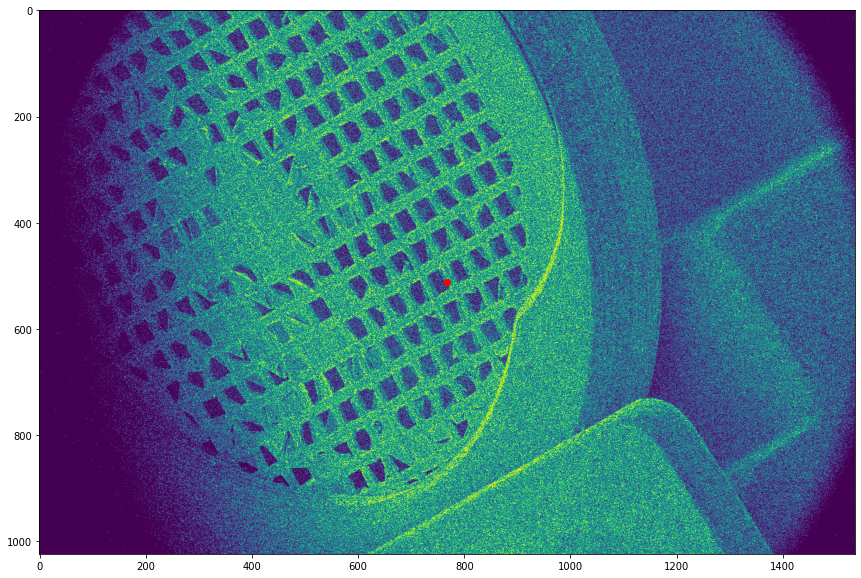

In [138]:
file_alignment = [f for f in files if '_'+ str(angle) in f]
img_alignment = cv2.imread(os.path.join(folder,file_alignment[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(img_alignment)
plt.plot(img_alignment.shape[1]/2, img_alignment.shape[0]/2,'ro')

# Calculate the pixel size with the knows HFW of 3mm

In [146]:
pixel_size = 3e-3 / img_alignment.shape[0]
print("Pixel Size / micron: {}".format(pixel_size * 1e6))

Pixel Size / micron: 2.9296875


# Detect image features by ORB (Oriented FAST and Rotated Brief)

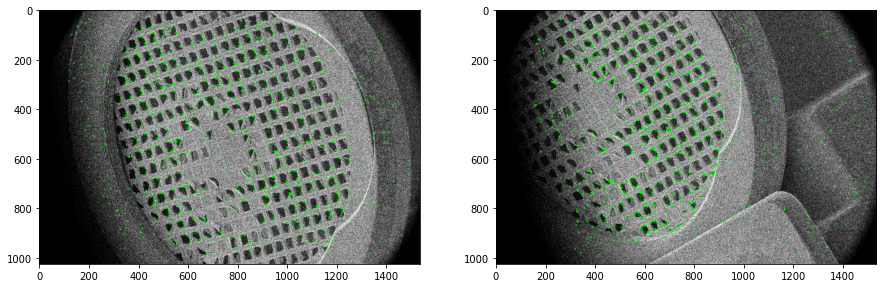

In [150]:
def detect_and_plot(image, axes,N_FEATURES=2000):
    orb = cv2.ORB_create(nfeatures=N_FEATURES)
    kp, des = orb.detectAndCompute(image, None)
    kp_img = cv2.drawKeypoints(image, kp, None, color=(0, 255, 0), flags=0)
    axes.imshow(kp_img)


fig, axes = plt.subplots(1,2)
detect_and_plot(img_reference,axes[0])
detect_and_plot(img_alignment, axes[1])

# Match features of 0° and the above specified angle images
## Helper function and execution

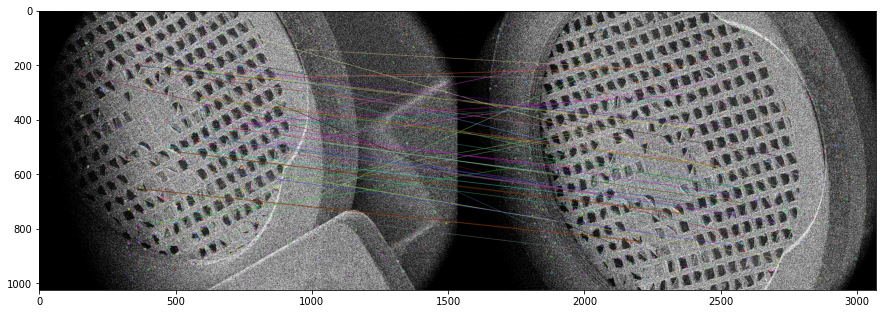

In [141]:
def matchFeatures(img_to_align, img_reference, MIN_MATCHES=50, N_FEATURES=2000, DISPLAY_MATCHES=False):
    orb = cv2.ORB_create(nfeatures=2000)
    kp1, des1 = orb.detectAndCompute(img_to_align, None)
    kp2, des2 = orb.detectAndCompute(img_reference, None)

    index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
    search_params = {}
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # As per Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > MIN_MATCHES:
        src_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        m, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
        corrected_img = cv2.warpPerspective(img_to_align, m, (img_reference.shape[1], img_reference.shape[0]))
        if DISPLAY_MATCHES:            
            match_img = cv2.drawMatches(img_to_align, kp1, img_reference, kp2, good_matches[:50], None)
            plt.imshow(match_img)

        return corrected_img, m
    else:
        print('Matching failed')
        return None, None
        
corrected_img, transformationMatrix = matchFeatures(img_reference=img_reference, img_to_align= img_alignment, DISPLAY_MATCHES=True)




## Plot the results

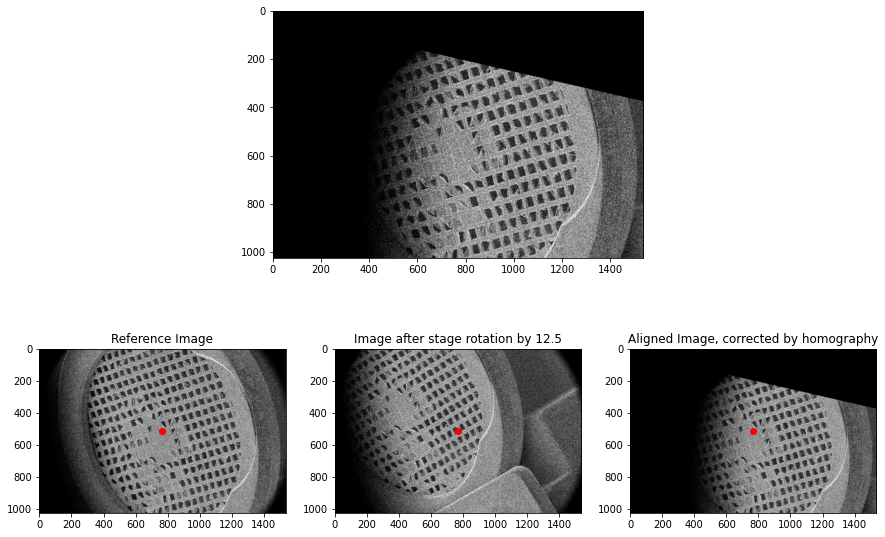

In [156]:
if corrected_img is not None:
    fig, axarr = plt.subplot_mosaic("AAA;BCD")
    axarr["A"].imshow(corrected_img, cmap='gist_gray') 
    axarr["B"].imshow(img_reference, cmap='gist_gray') 
    axarr["B"].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
    axarr["B"].set_title('Reference Image')
    axarr["D"].imshow(corrected_img, cmap='gist_gray') 
    axarr["D"].plot(corrected_img.shape[1]/2, corrected_img.shape[0]/2,'ro')
    axarr["D"].set_title('Aligned Image, corrected by homography')
    axarr["C"].imshow(img_alignment, cmap='gist_gray') 
    axarr["C"].plot(img_alignment.shape[1]/2, img_alignment.shape[0]/2,'ro')
    axarr["C"].set_title('Image after stage rotation by ' + str(angle))
    plt.show()

## Calculate the translation, scaling and rotation vector from the transformation matrix

In [157]:
def get_params_from_transformation_matrix(m, pixe_size=0.0, PRINT=False):
    if np.abs(m[2,0]) > 1e-5 or np.abs(m[2,1]) > 1e-5 :
        print("This is no valid transformation matrix, the projection component is too large.")
        return None
    else:
        a,b,c,d = m[0,0], m[0,1], m[1,0], m[1,1]
        result = {}
        result['t'] = [m[0,2], m[1,2]]
        sx, sy = np.sqrt(a ** 2 + c ** 2) , np.sqrt(b ** 2 + d ** 2)
        result['s']  = [sx, sy]
        phi1,phi2 = np.rad2deg(np.arctan((c/sx)/(d/sy))), np.rad2deg(np.arctan((-b/sy)/(a/sx)))
        result['phi']  = [phi1,phi2, np.mean([phi1,phi2])]
        if pixe_size > 0.0:
            result['t'] =[ t * pixel_size for t in result['t']]

        if PRINT:                        
            print("Image Transformation\n")
            print("{}\n".format(transformationMatrix))
            if pixel_size > 0.0:         
                print("Translation (x,y) / mm: {:.2f}, {:.2f}".format(m[0,2]*1e3*pixel_size,m[1,2]*1e3*pixel_size))
            print("Translation (x,y) / px: {}, {}\n".format(round(m[0,2],0),round(m[1,2]),0))
            print("Scaling (x,y): {}, {}\n".format(result['s'][0], result['s'][1]))
            print("Rotation Angle (x,y, mean): {}, {}, {}".format(phi1,phi2 ,round(result['phi'][2],2)))
        return result



params = get_params_from_transformation_matrix(transformationMatrix, pixe_size=pixel_size, PRINT=True)





Image Transformation

[[ 9.83031538e-01 -2.29347394e-01  4.38184439e+02]
 [ 2.24659185e-01  9.63813791e-01  1.26548630e+02]
 [-4.91761712e-06  2.24276927e-07  1.00000000e+00]]

Translation (x,y) / mm: 1.28, 0.37
Translation (x,y) / px: 438.0, 127

Scaling (x,y): 1.0083762958232079, 0.9907256183674463

Rotation Angle (x,y, mean): 12.899091274397191, 13.358201106983916, 13.13


# Test Bed

In [ ]:
# Init running variables
deltaR = angle * math.pi / 180
itrations = 10
rotation_center = (.0,.0)  
pos_rotation = []
pos_rotation_aligned = []   
pos_estimated = []  
pos_alignment = []
pos_estimated_vector = []

pos_alignment = positions[0]
pos_alignment['x'] = -2.1915e-3
pos_alignment['y'] = -4.3908e-3
pos_alignment['z'] = 6.9725e-3
pos_alignment['t'] = 0.0
pos_alignment['r'] = 2*math.pi # radians!

printPositionNicely(pos_alignment)



Position / mm:
x: -2.1915
y: -4.3908
z: 6.9725
t: 0.0
r: 0.0 360.0


In [ ]:
i = 0
# Estimate coordinates of rotated point with estimated center of rotation
matrix = get_rotation_matrix_offset(deltaR,rotation_center)
print(matrix)

pos_estimated_vector = np.dot(get_rotation_matrix_offset(deltaR,rotation_center),np.array([pos_alignment['x'], pos_alignment['y'],1]))
pos_estimated.append(pos_alignment.copy())
pos_estimated[i]['x'] = pos_estimated_vector[0]
pos_estimated[i]['y'] = pos_estimated_vector[1]
pos_estimated[i]['r'] = pos_alignment['r'] - deltaR

printPositionNicely(pos_estimated[0])

[[ 0.99144486 -0.13052619  0.        ]
 [ 0.13052619  0.99144486  0.        ]
 [ 0.          0.          1.        ]]
Position / mm:
x: -1.5996
y: -4.6393
z: 6.9725
t: 0.0
r: -7.5 352.5


In [ ]:
print('Alignment:')
printPositionNicely(positions[2])

Alignment:
Position / mm:
x: -1.9258
y: -4.379
z: 6.9725
t: 0.0
r: -7.5 352.5


In [ ]:
# Kill kernel
#os._exit(00)

(1024, 1536)
[-35.960000000000036, 211.91999999999996]


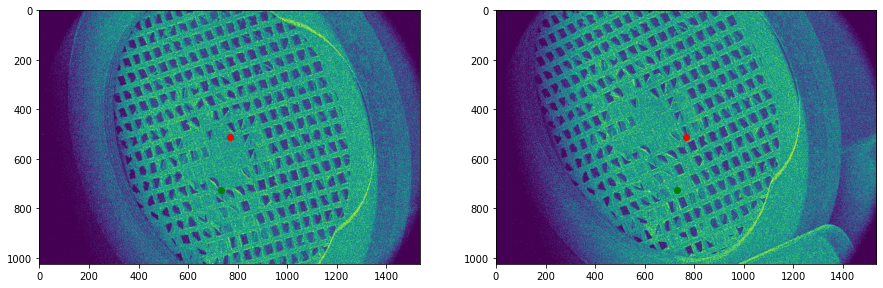

In [ ]:
#Take alignment image and save position
img_rotated = img_alignment.copy()
print(img_rotated.shape)

def correlateImages(img0, img1, VERBOSE = False):
    img0, img1 = np.float32(img0),np.float32(img1)
    #Align images and save the offset
    center_x, center_y, score = phase_correlate(np.float32(img_reference), np.float32(img_rotated))
    if VERBOSE:
        print("Center X / px: {}\nCenter Y / px: {}\nScore: {}\n".format(center_x,center_y, score))
        print("Center X / %: {}\nCenter Y / %: {}\n".format(center_x/img_reference.shape[1]*100,center_y/img_reference.shape[0]*100))
    return center_x, center_y, score


c_x, c_y, score = correlateImages(img_reference, img_rotated)

offset = []
offset.append(c_x - img_reference.shape[1]/2)
offset.append(c_y - img_reference.shape[0]/2)
print(offset)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_reference)
axarr[0].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
axarr[0].plot(c_x,c_y,'go')
axarr[1].imshow(img_rotated) 
axarr[1].plot(img_rotated.shape[1]/2, img_rotated.shape[0]/2,'ro')
axarr[1].plot(c_x,c_y,'go')

[-35.960000000000036, 211.91999999999996]


Text(0.5, 1.0, 'Image after stage rotation by 7.5')

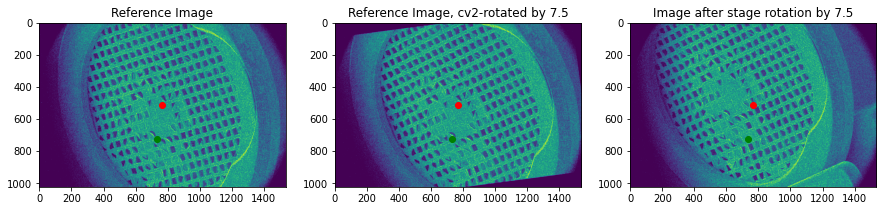

In [ ]:
height, width = np.shape(img_reference)[0], np.shape(img_reference)[1]
center = (width/2, height/2)
rotated_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)
img_reference_rotated = cv2.warpAffine(src=img_reference, M=rotated_matrix, dsize=(width, height))

c_x, c_y, score = correlateImages(img_reference_rotated, img_rotated)

offset = []
offset.append(c_x - img_reference.shape[1]/2)
offset.append(c_y - img_reference.shape[0]/2)
print(offset)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(img_reference)
axarr[0].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
axarr[0].plot(c_x,c_y,'go')
axarr[0].set_title('Reference Image')
axarr[1].imshow(img_reference_rotated) 
axarr[1].plot(img_reference_rotated.shape[1]/2, img_reference_rotated.shape[0]/2,'ro')
axarr[1].plot(c_x,c_y,'go')
axarr[1].set_title('Reference Image, cv2-rotated by ' + str(angle))
axarr[2].imshow(img_rotated) 
axarr[2].plot(img_rotated.shape[1]/2, img_rotated.shape[0]/2,'ro')
axarr[2].plot(c_x,c_y,'go')
axarr[2].set_title('Image after stage rotation by ' + str(angle))

Deviation (in mm): 0.6297343211597902
Moving stage by (0.00010535156250000011,-0.0006208593749999999) and resetting beam shift...
Deviation (in mm): 0.4787790936028758
Moving stage by (-0.0002696484374999999,-0.0003956249999999999) and resetting beam shift...
Deviation (in mm): 2.2737491883228738
Moving stage by (-0.0005392968750000002,0.0022088671875) and resetting beam shift...


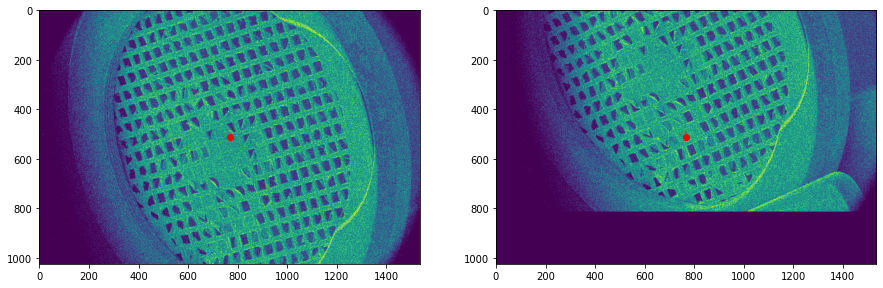

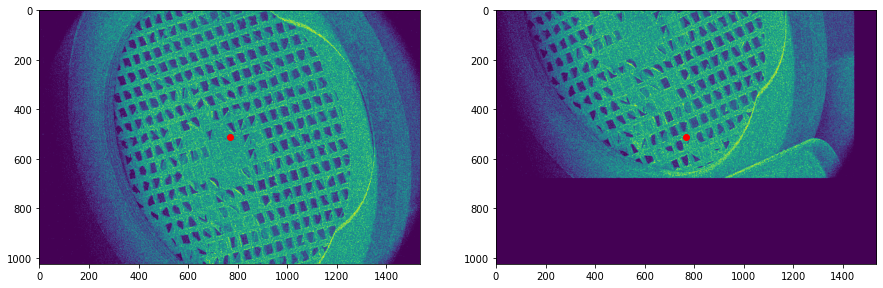

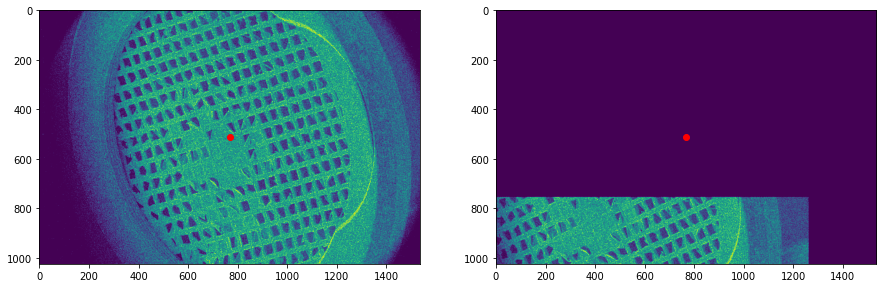

In [ ]:
# Try to reduce offset as much as possible in three x-y-moves
move_count = 0
l_center_in_meters_x = offset[0] * pixel_size
l_center_in_meters_y = offset[1] * pixel_size
while score < 0.98 and move_count < 3:
    x = l_center_in_meters_x * -1  # sign may need to be flipped depending on matcher
    y = l_center_in_meters_y * -1
    distance = np.sqrt(x ** 2 + y ** 2)
    print("Deviation (in mm): " + str(distance*1e3))

    # move stage and reset beam shift
    print("Moving stage by ("+str(x)+","+str(y)+") and resetting beam shift...")

    
    transform = np.float32([ [1,0,-offset[0]], [0,1,-offset[1]]] )
    img_rotated = cv2.warpAffine(img_rotated, transform, (img_rotated.shape[1],img_rotated.shape[0]) )

    move_count += 1

    c_x, c_y, score = correlateImages(img_reference, img_rotated)

    offset[0] = c_x - img_reference.shape[0]/2
    offset[1] = c_y - img_reference.shape[1]/2
    l_center_in_meters_x = offset[0] * pixel_size
    l_center_in_meters_y = offset[1] * pixel_size

    
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img_reference)
    axarr[0].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
    axarr[1].imshow(img_rotated) 
    axarr[1].plot(img_rotated.shape[1]/2, img_rotated.shape[0]/2,'ro')

#pos_rotation_aligned.append(self.getStagePosition())

# Calculate the difference between the rotated and aligned position
#rotation_difference = {key: pos_rotation_aligned[key] - pos_rotation.get(key, 0) for key in pos_rotation_aligned}
#rotation_difference_vector = np.array(rotation_difference['x'], rotation_difference['y'])

#rotation_center_new = self.get_rotation_matrix_inverse(angle) * rotation_difference_vector

#rotation_center = rotation_center + (rotation_center - rotation_center_new) * 0.75